<a href="https://colab.research.google.com/github/deb3011/ml_datascience/blob/main/rate_hc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df = pd.read_csv("/train.csv")

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.iloc[3]["comment_text"]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

Pre-processing

In [ ]:
#lowercasing
df["comment_text"]= df["comment_text"].str.lower()
print(df["comment_text"][0])

explanation
why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27


In [ ]:
import string, time
exclude = string.punctuation
# removing punction
def remove_pun2(text):
    return text.translate(str.maketrans("", "", exclude ))
df["comment_text"] = df["comment_text"].apply(remove_pun2)

In [ ]:
#    # !pip install spacy
# import spacy
# nlp =spacy.load("en_core_web_sm")  #tokenization

In [ ]:
# from nltk.stem.porter import PorterStemmer    #stemming
# ps = PorterStemmer()
# def stem_words(text):
#     return " ".join([ps.stem(word) for word in text.split()])

# df["comment_text"] = df["comment_text"].apply(stem_words)

In [ ]:
from tensorflow.keras.layers import TextVectorization
X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
MAX_FEATURES = 200000 # number of words in the vocab

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
# X = tf.convert_to_tensor(X.values)
vectorizer.adapt(X.values)

In [ ]:
vectorizer("Hello world! Life is great")

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263, 306, ...,   0,   0,   0])>

In [ ]:
vectorized_text = vectorizer(X.values)
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32456,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [ ]:
# Data pipeline sequence - map, cache, shuffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
dataset.as_numpy_iterator().next()

(array([[   20,     7,   382, ...,     0,     0,     0],
        [  917,   562,   179, ...,     0,     0,     0],
        [  280,     5,     1, ...,     0,     0,     0],
        ...,
        [   15,   164,     3, ...,     0,     0,     0],
        [23923,    11,  8569, ...,     0,     0,     0],
        [   39,     7,    15, ...,     0,     0,     0]]),
 array([[1, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

Sequential Model

In [ ]:
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 764s 108ms/step - loss: 0.0620 - val_loss: 0.0466


In [ ]:
# plt.figure(figsize=(8,5))
# pd.DataFrame(history.history).plot()
# plt.show()

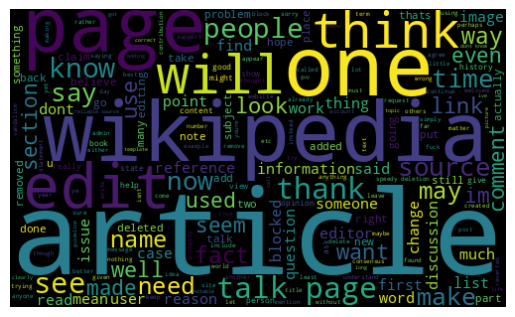

In [ ]:
## plot word Cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

allWords=' '.join([cmnts for cmnts in df['comment_text']])
wordCloud=WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear' )
plt.axis('off')
plt.show()

Make prediction

In [ ]:

input_text = vectorizer('You freaking! I am going to hit you.')
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 724ms/step


In [ ]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,    8, ...,    0,    0,    0])>

In [ ]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 62ms/step


array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
res.shape

(1, 6)

Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 93ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8140963315963745, Recall:0.7047299146652222, Accuracy:0.4874624013900757


Text and Gradio

In [ ]:
!pip install gradio jinja2
import tensorflow as tf
import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.9 MB/s eta 0

In [ ]:
model.save('hatred.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('hatred.h5')

In [ ]:
input_str = vectorizer('i am going to kill you')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 2s 2s/step


In [ ]:
print(df.columns[2:])
print(res)

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')
[[0.8336906  0.01916042 0.45913628 0.02307083 0.4752398  0.05101461]]


In [ ]:
# def score_comment(comment):
#     vectorized_comment = vectorizer([comment])
#     results = model.predict(vectorized_comment)

#     text = ''
#     for idx, col in enumerate(df.columns[2:]):
#         text += '{}: {}\n'.format(col, results[0][idx]>0.5)

#     return text

# interface = gr.Interface(fn=score_comment,
#                          inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
#                         outputs='text')
# interface.launch()
